In [38]:
# Imports and hyperparams
%matplotlib inline
import os
import cv2
import numpy as np
import scipy.io as sio
from DenseDepthModel import DenseDepth
from models.data.data_utils.sid_utils import SID
from remove_dc_from_spad import remove_dc_from_spad_edge
from weighted_histogram_matching import image_histogram_match
# from spad_utils import rescale_bins
import h5py
import matplotlib.pyplot as plt
rootdir = "data/8_30_Hallway"

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

def loadmat_h5py(file):
    output = {}
    with h5py.File(file, 'r') as f:
        for k, v in f.items():
            output[k] = np.array(v)
    return output

def z_to_r_kinect(z):
    fc = [1053.622, 1047.508]  # Focal length in pixels
    yy, xx = np.meshgrid(range(z.shape[0]), range(z.shape[1]), indexing="ij")
    x = (xx * z) / fc[0]
    y = (yy * z) / fc[1]
    r = np.sqrt(x**2 + y**2 + z**2)
    return r

def r_to_z_kinect(r):
    fc = [1053.622, 1047.508]  # Focal length in pixels
    yy, xx = np.meshgrid(range(r.shape[0]), range(r.shape[1]), indexing="ij")
    z = r / np.sqrt((xx/fc[0])**2 + (yy/fc[1])**2 + 1)
    return z

In [3]:
# Calibration data
print("Loading calibration data...")
calib = loadmat_h5py(os.path.join(rootdir, "calibration.mat"))


Loading calibration data...


In [4]:
# Load SPAD data

# Ambient data
# print("Loading ambient data...")
# spad_ambient = loadmat_h5py(os.path.join(rootdir, "ambient", "data_accum.mat"))
# ambient_scaled = spad_ambient["mat"]
# ambient_estimate = (n_spad_frames/n_ambient_frames)*np.mean(np.sum(spad_ambient["mat"], axis=(0,1)))
# np.save(os.path.join(rootdir, "ambient_estimate.npy"), ambient_estimate)
# print(ambient_estimate)
# ambient_relevant = np.load(os.path.join(rootdir, "ambient_estimate.npy"))

# SPAD data
print("Loading SPAD data...")
# spad = loadmat_h5py(os.path.join(rootdir, "spad", "data_accum.mat"))
# spad_relevant = spad["mat"][..., min_depth_bin:max_depth_bin]
# np.save(os.path.join(rootdir, "spad_relevant.npy"), spad_relevant)
spad_relevant = np.load(os.path.join(rootdir, "spad_relevant.npy"))



min depth, max_depth
0.6 6.0
250 2500
Loading SPAD data...


<BarContainer object of 4096 artists>

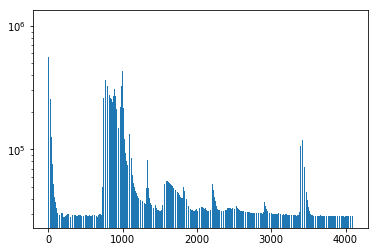

In [5]:
# Determine appropriate min and max depths
spad_single = np.sum(spad["mat"], axis=(0,1))
plt.bar(range(len(spad_single)), spad_single, log=True)

In [9]:
# Extract relevant subset of SPAD and save
bin_width_ps = 16  # Bin width is 16 ps
bin_width_m = bin_width_ps*3e8/(2*1e12)
min_depth = 0.6  # Reject internal reflections
min_depth_bin = int(min_depth/bin_width_m)
max_depth = 9.
max_depth_bin = int(max_depth/bin_width_m)
print("min depth, max_depth")
print(min_depth, max_depth)
print(min_depth_bin, max_depth_bin)

spad_relevant = spad["mat"][..., min_depth_bin:max_depth_bin]
np.save(os.path.join(rootdir, "spad_relevant.npy"), spad_relevant)
# spad_relevant = np.load(os.path.join(rootdir, "spad_relevant.npy"))

min depth, max_depth
0.6 9.0
250 3750


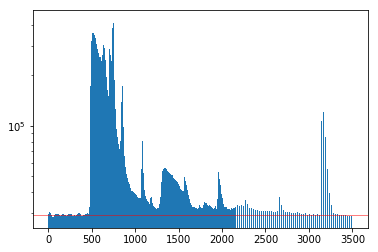

In [10]:
hist = np.sum(spad_relevant, axis=(0,1))
plt.figure()
plt.bar(range(len(hist)), hist, log=True)
ambient_estimate = np.mean(hist[:400])
plt.axhline(ambient_estimate, color='r', linewidth=0.5)

(-0.5, 511.5, 511.5, -0.5)

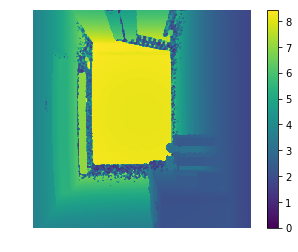

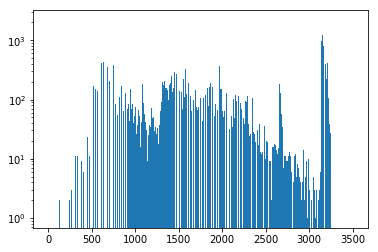

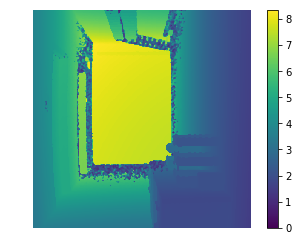

In [11]:
# Get Ground truth depth
import scipy.signal as signal
gt_idx = np.argmax(spad_relevant, axis=2)
gt_r = signal.medfilt(np.fliplr(np.flipud(((gt_idx + min_depth_bin) * bin_width_m).T)), kernel_size=5)
plt.figure()
plt.imshow(gt_r)
plt.colorbar()
plt.axis('off')

gt_r_hist, _ = np.histogram(gt_r, range=(min_depth, max_depth), bins=spad_relevant.shape[2])
plt.figure()
plt.bar(range(len(gt_r_hist)), gt_r_hist, log=True)

gt_z = r_to_z_kinect(gt_r)
plt.figure()
plt.imshow(gt_z)
plt.colorbar()
plt.axis("off")




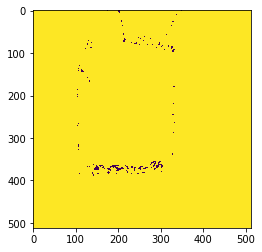

In [16]:
# Create mask
# Scanning doesn't work for dark objects or low angle of attack
mask_threshold = 1.7
mask = gt_r >= mask_threshold
plt.imshow(mask)

Loading kinect data...
0
0


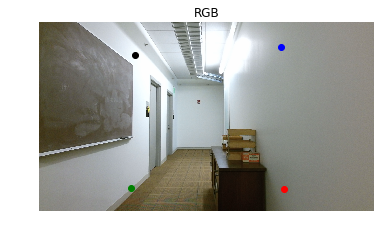

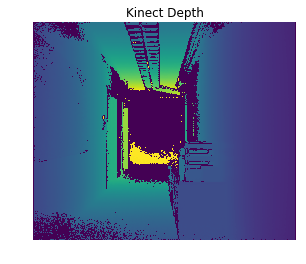

In [25]:
# Kinect data
print("Loading kinect data...")
kinect = loadmat_h5py(os.path.join(rootdir, "kinect.mat"))
# Transpose and visualize
plt.figure()
kinect_rgb = np.fliplr(kinect["rgb_im"].transpose(2, 1, 0))
plt.imshow(kinect_rgb)
plt.title("RGB")
plt.axis("off")
plt.plot(calib["pos_00"][1], calib["pos_00"][0], "ro")
plt.plot(calib["pos_01"][1], calib["pos_01"][0], "bo")
plt.plot(calib["pos_10"][1], calib["pos_10"][0], "go")
plt.plot(calib["pos_11"][1], calib["pos_11"][0], "ko")

# print(calib["pos_00"]) # position 0 is the row, position 1 is the column
# Extract crop
top = (calib["pos_01"][0] + calib["pos_11"][0])//2
bot = (calib["pos_10"][0] + calib["pos_00"][0])//2
left = (calib["pos_11"][1] + calib["pos_10"][1])//2
right = (calib["pos_01"][1] + calib["pos_00"][1])//2
# Correct so that side lengths work out
crop = (int(top[0])-6, int(bot[0])+6, int(left[0])-5, int(right[0])+4)
print((crop[1] - crop[0]) % 32)
print((crop[3] - crop[2]) % 32)

plt.figure()
kinect_depth = np.fliplr(kinect["depth_im"].transpose(1, 0))
plt.imshow(kinect_depth)
plt.title("Kinect Depth")
plt.axis("off");

In [6]:
# Load camera intrinsics
# From https://link.springer.com/chapter/10.1007/978-3-662-47487-7_17
fc = [1053.622, 1047.508]  # Focal length in pixels
cc = [950.3941, 527.3442]  # Principal point
s = 0.                     # Skew

# Adjust principal point using crop
cc[0] -= crop[2]
cc[1] -= crop[0]

print(cc)

[446.3941, 389.3442]


Instructions for updating:
Colocations handled automatically by placer.


/home/markn1/anaconda3/envs/depth-net/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



Existing model loaded.

Model created.


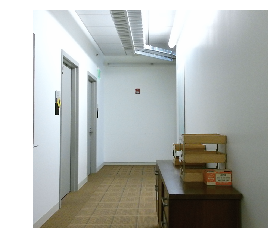

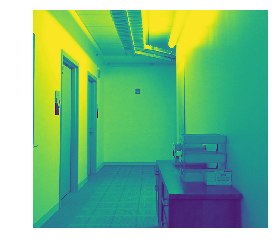

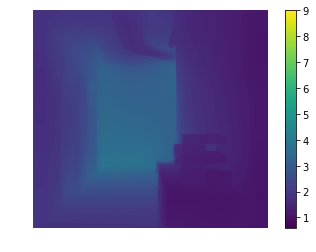

In [26]:
# Crop and run RGB through network
rgb_cropped = kinect_rgb[crop[0]:crop[1], crop[2]:crop[3], :]
plt.imshow(rgb_cropped)
plt.axis("off")

# Extract intensity
intensity = rgb_cropped[:,:,0]
plt.figure()
plt.imshow(intensity)
plt.axis("off")
weights = intensity/255.

model = DenseDepth()
z_init = model.predict(rgb_cropped)[0,...]
plt.figure()
plt.imshow(z_init, vmin=min_depth, vmax=max_depth)
plt.axis("off")
plt.colorbar()


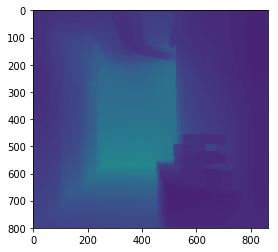

In [27]:
# Convert depth to radial distance using intrisics
r_init = z_to_r_kinect(z_init)
plt.imshow(r_init, vmin=min_depth, vmax=max_depth)


<BarContainer object of 3500 artists>

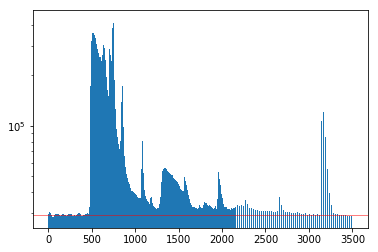

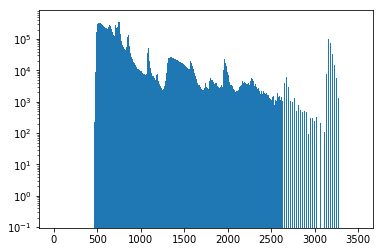

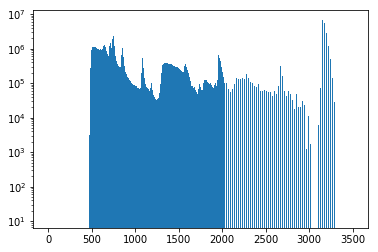

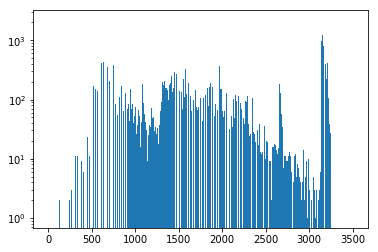

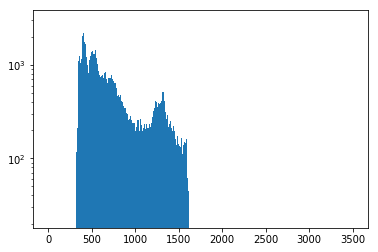

In [51]:
# Preprocess SPAD
sid_obj = SID(sid_bins=140, alpha=min_depth, beta=max_depth, offset=-min_depth/2)

spad_single = np.sum(spad_relevant, axis=(0,1))
plt.bar(range(len(spad_single)), spad_single, log=True)
# Estimate Ambient
ambient_estimate = np.mean(spad_single[:400])
# ambient_estimate = np.mean(np.sum(ambient_relevant, axis=(0,1)))
plt.axhline(y=ambient_estimate, color='r', linewidth=0.5)


# Remove DC
spad_denoised = remove_dc_from_spad_edge(spad_single, ambient_estimate)
plt.figure()
plt.bar(range(len(spad_denoised)), spad_denoised, log=True)

# Correct Falloff
bin_edges = np.linspace(min_depth, max_depth, len(spad_denoised) + 1)
bin_values = (bin_edges[1:] + bin_edges[:-1])/2
spad_corrected = spad_denoised * bin_values ** 2
plt.figure()
plt.bar(range(len(spad_corrected)), spad_corrected, log=True)

# GT for comparison
gt_r_hist, _ = np.histogram(gt_r, range=(min_depth, max_depth), bins=spad_relevant.shape[2])
plt.figure()
plt.bar(range(len(gt_r_hist)), gt_r_hist, log=True)

# Initial Depth Histogram
r_init_hist, _ = np.histogram(r_init, range=(min_depth, max_depth), bins=spad_relevant.shape[2])
plt.figure()
plt.bar(range(len(r_init_hist)), r_init_hist, log=True)

In [52]:
def rescale_bins(spad_counts, min_depth, max_depth, sid_obj):
    """
    Works in Numpy
    :param spad_counts: The histogram of spad counts to rescale.
    :param min_depth: The minimum depth of the histogram.
    :param max_depth: The maximum depth of the histogram.
    :param sid_obj: An object representing a SID.
    :return: A rescaled histogram in time to be according to the SID

    Assign photons to sid bins proportionally according to the amount of overlap between
    the sid bin range and the spad_count bin.
    """

    sid_bin_edges_m = sid_obj.sid_bin_edges - sid_obj.offset
#     print(sid_bin_edges_m)
    # Convert sid_bin_edges_m into units of spad bins
    sid_bin_edges_bin = sid_bin_edges_m * len(spad_counts) / (max_depth - min_depth)
    sid_bin_edges_bin -= sid_bin_edges_bin[0]  # Start at 0
    sid_bin_edges_bin[-1] = np.floor(sid_bin_edges_bin[-1])
    # print(sid_bin_edges_bin[-1])
    # Map spad_counts onto sid_bin indices
#     print(sid_bin_edges_bin)
    sid_counts = np.zeros(sid_obj.sid_bins)
    for i in range(sid_obj.sid_bins):
#         print(i)
        left = sid_bin_edges_bin[i]
        right = sid_bin_edges_bin[i + 1]
        curr = left
        while curr != right:
#             print(curr)
            curr = np.min([right, np.floor(left + 1.)])  # Don't go across spad bins - stop at integers
            sid_counts[i] += (curr - left) * spad_counts[int(np.floor(left))]
            # Update window
            left = curr

    return sid_counts

<BarContainer object of 140 artists>

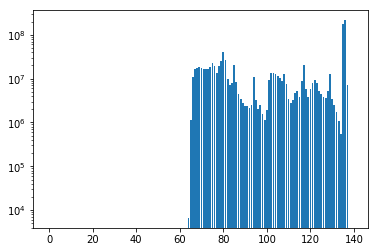

In [53]:
# Convert to SID
spad_sid = rescale_bins(spad_corrected, min_depth, max_depth, sid_obj)
plt.figure()
# plt.bar(range(len(spad_sid)), spad_sid)
plt.bar(range(len(spad_sid)), spad_sid, log=True)

<BarContainer object of 140 artists>

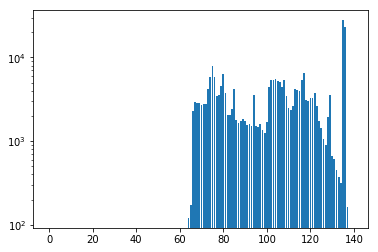

In [54]:
# Show SID gt histogram
# gt_hist, _ = np.histogram(gt, range=(min_depth, max_depth), bins=len(spad_denoised))

# Show gt histogram for reference
gt_r_idx = sid_obj.get_sid_index_from_value(gt_r[mask > 0])
gt_r_hist, _ = np.histogram(gt_r_idx, bins=range(sid_obj.sid_bins + 1))
plt.figure()
plt.bar(range(len(gt_r_hist)), gt_r_hist, log=True)

In [55]:
spad_sid = spad_sid * np.sum(gt_r_hist)/np.sum(spad_sid)

<BarContainer object of 140 artists>

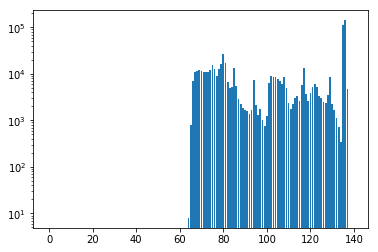

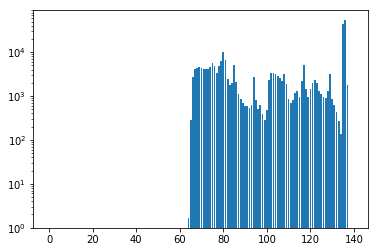

In [65]:
# Perform histogram matching
# r_pred, _ = image_histogram_match(r_init, spad_sid, weights, sid_obj)
r_pred, _ = image_histogram_match(r_init, spad_sid, np.ones_like(r_init), sid_obj)
r_pred_idx = sid_obj.get_sid_index_from_value(r_pred)
r_pred_hist, _ = np.histogram(r_pred_idx, bins=range(sid_obj.sid_bins+1))
plt.figure()
plt.bar(range(len(r_pred_hist)), r_pred_hist, log=True)
plt.figure()
plt.bar(range(len(spad_sid)), spad_sid, log=True)

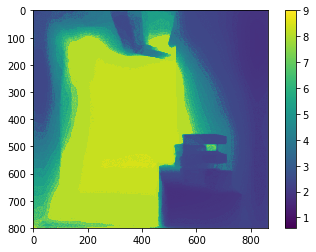

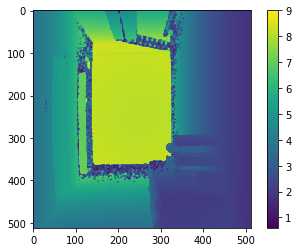

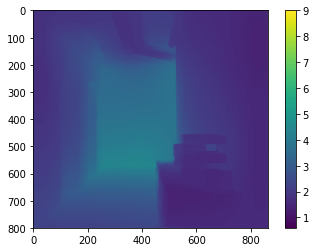

In [66]:
plt.figure()
plt.imshow(r_pred, vmin=min_depth, vmax=max_depth)
plt.colorbar()

plt.figure()
plt.imshow(gt_r, vmin=min_depth, vmax=max_depth)
plt.colorbar()

plt.figure()
plt.imshow(r_init, vmin=min_depth, vmax=max_depth)
plt.colorbar()

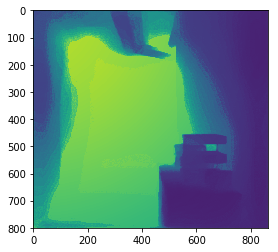

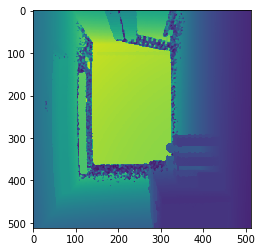

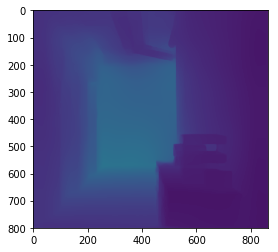

In [67]:
# Convert GT image to RGB-D, convert RGB-R output to RGB-D, compare
z_pred = r_to_z_kinect(r_pred)
gt_z = r_to_z_kinect(gt_r)
z_init = r_to_z_kinect(r_init)
plt.figure()
plt.imshow(z_pred, vmin=min_depth, vmax=max_depth)

plt.figure()
plt.imshow(gt_z, vmin=min_depth, vmax=max_depth)

plt.figure()
plt.imshow(z_init, vmin=min_depth, vmax=max_depth)



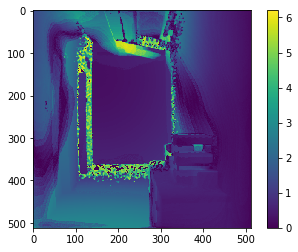

In [59]:
plt.figure()
z_pred_resized = cv2.resize(z_pred, gt_z.shape)
plt.imshow(np.abs(z_pred_resized - gt_z)*mask)
plt.colorbar()

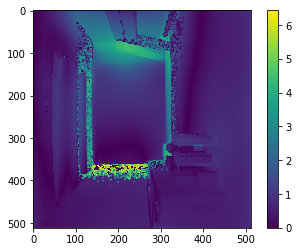

In [60]:
plt.imshow(np.abs(z_median_resized - gt_z)*mask)
plt.colorbar()

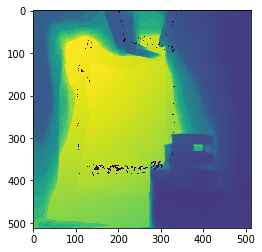

In [61]:
plt.imshow(z_pred_resized*mask)

In [62]:
def hist_match(source, template):
    """
    From https://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x

    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

In [63]:
# Calculate metrics, plot results, generate figures
import torch
import cv2
from models.loss import get_depth_metrics
def pprint_metrics(metrics):
    print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('d1', 'd2', 'd3', 'rel', 'rmse', 'log_10'))
    print(
        "{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(metrics["delta1"],
                                                                            metrics["delta2"],
                                                                            metrics["delta3"],
                                                                            metrics["rel_abs_diff"],
                                                                            metrics["rmse"],
                                                                            metrics["log10"]))

    
gt_z[gt_z == 0] = 1e-3  # Clip to avoid numerical issues

z_pred_resized = cv2.resize(z_pred, gt_z.shape)
pred_metrics = get_depth_metrics(torch.from_numpy(z_pred_resized),
                  torch.from_numpy(gt_z),
                  torch.from_numpy(mask).float())

z_median = z_init*np.median(gt_z)/np.median(z_init)
z_median_resized = cv2.resize(z_median, gt_z.shape)
median_metrics = get_depth_metrics(torch.from_numpy(z_median_resized),
                  torch.from_numpy(gt_z),
                  torch.from_numpy(mask).float())

z_matched = hist_match(z_init, gt_z)
z_matched_resized = cv2.resize(z_matched, gt_z.shape)
matched_metrics = get_depth_metrics(torch.from_numpy(z_matched_resized),
                  torch.from_numpy(gt_z),
                  torch.from_numpy(mask).float())


z_init_resized = cv2.resize(z_init, gt_z.shape)
init_metrics = get_depth_metrics(torch.from_numpy(z_init_resized),
                  torch.from_numpy(gt_z),
                  torch.from_numpy(mask).float())

print("Before:")
pprint_metrics(init_metrics)

print("Median:")
pprint_metrics(median_metrics)

print("GT Histogram Matching:")
pprint_metrics(matched_metrics)

print("After:")
pprint_metrics(pred_metrics)

print("Standard Dev. of scene: {}".format(np.std(gt_z[mask > 0.])))


Before:
        d1,         d2,         d3,        rel,       rmse,     log_10
    0.0241,     0.1470,     0.4485,     0.4993,     2.8558,     0.3119
Median:
        d1,         d2,         d3,        rel,       rmse,     log_10
    0.6132,     0.9068,     0.9634,     0.2473,     1.2725,     0.0959
GT Histogram Matching:
        d1,         d2,         d3,        rel,       rmse,     log_10
    0.7733,     0.9225,     0.9570,     0.1910,     1.2962,     0.0729
After:
        d1,         d2,         d3,        rel,       rmse,     log_10
    0.4517,     0.7759,     0.9264,     0.3180,     1.6322,     0.1306
Standard Dev. of scene: 2.1804871365267444


<BarContainer object of 140 artists>

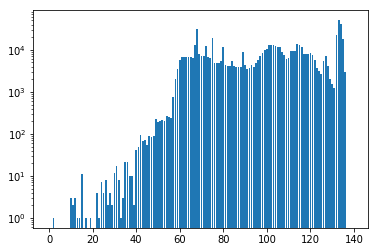

In [64]:
z_matched_idx = sid_obj.get_sid_index_from_value(z_matched)
z_matched_hist, _ = np.histogram(z_matched_idx, range(sid_obj.sid_bins + 1))
plt.bar(range(len(z_matched_hist)), z_matched_hist, log=True)